# Q Tensor POD FEM Experiments

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# everything is in other_functions.py
# except main functions for running
# POD FEM and vanilla FEM
from other_functions import *

from vanilla_fem import *
from pod_fem import *

## Define Parameters

In [2]:
# Omega = [0, Lx] x [0, Lx]
# Lx is currently hard coded as 2 in mesh generation, 
# so changing this does nothing.
Lx = 2 

# model parameters
a = -0.2
b = 1
c = 1
A0 = 500
M = 1
sigma = 1.0
L1 = 0.1

# number of time steps and final time
Nt = 200
t_final = 5
tVals = np.linspace(0, t_final, Nt)
dt = tVals[1] - tVals[0] # delta t

## FEM Simulation on Course Mesh

In [3]:
# define the mesh in space
mesh, interior_point_coords = get_triangulation(refinements=5)

# Get vectors for the components of matrices (flattened over space) 
# over time with time 0 initialized.
# We only keep track of nodes in the interior of \Omega because we
# use homogeneous Dirichlet boundary conditions.
Q1, Q2, p1, p2, r, num_interior_points = initialize_Q_flow(interior_point_coords, Nt, a, b, c, A0)

# Get the finite element space, stiffness matrix, lumped mass matrix as a vector, and mass matrix
Vh, stiffness_matrix, gamma, mass_matrix = calculate_basis_integrals(mesh)

# solve the PDE (updates the entries of Q1, Q2, etc. within the function)
solve_Q_flow(Q1, Q2, p1, p2, r, gamma, stiffness_matrix, Lx, t_final, Nt, a, b, c, A0, M, sigma, L1, dt)

Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 198/198 [00:02<00:00, 69.42it/s]


## Get the POD
We get the eigenvalues of $\Delta t \tilde{Q}^\top W\tilde{Q}$, where $\tilde Q$ is the snapshot matrix and $W$ is the mass matrix.

In [4]:
vals = get_POD_eigenvalues(Q1, Q2, r, dt, mass_matrix)

Let's look at the eigenvalues of $\Delta t\tilde{Q}^\top W\tilde{Q}$.

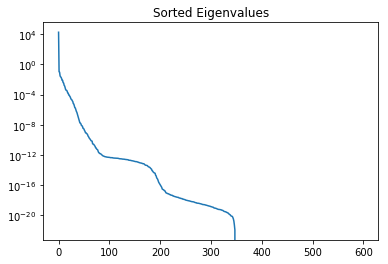

In [5]:
plt.plot(np.arange(vals.shape[0]), np.flip(vals))
plt.yscale("log")
plt.title("Sorted Eigenvalues")
plt.show()

We see that the eigenvalues quickly decay. Let's also look at the energy from retaining $\ell$ eigenvalues/eigenvectors.

Energy from keeping 40 eigenvalues: 0.9999999999903973


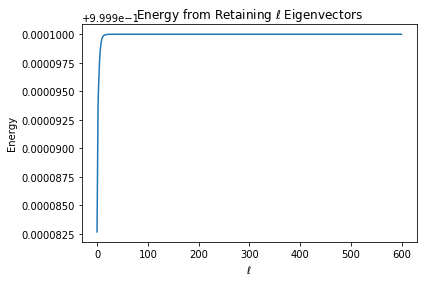

In [6]:
print("Energy from keeping 40 eigenvalues:", np.sum(vals[-40:])/np.sum(vals))
plt.plot(np.arange(vals.shape[0]), np.cumsum(np.flip(vals))/np.sum(vals))
plt.title("Energy from Retaining $\ell$ Eigenvectors")
plt.xlabel("$\ell$")
plt.ylabel("Energy")
plt.show()

In [7]:
Psi = get_Psi(Q1, Q2, r, dt, mass_matrix, rank=40)
Lambda = np.diag(gamma)
Q1_, Q2_, p1_, p2_, r_ = initialize_Q_flow_POD(Q1, Q2, p1, p2, r, Psi, mass_matrix)

solve_Q_flow_POD(Q1_, Q2_, p1_, p2_, r_, Psi, Lambda, stiffness_matrix, mass_matrix, Lx, t_final, Nt, a, b, c, A0, M, sigma, L1, dt)

Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████| 198/198 [00:01<00:00, 134.57it/s]


## Energy Stability

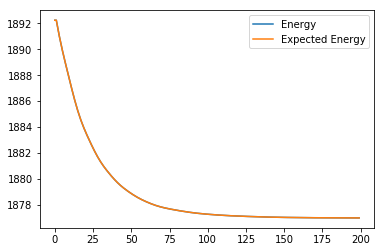

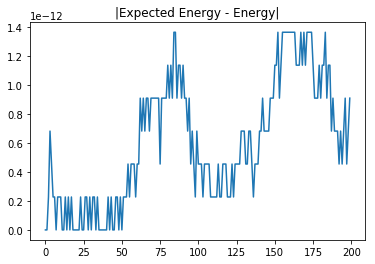

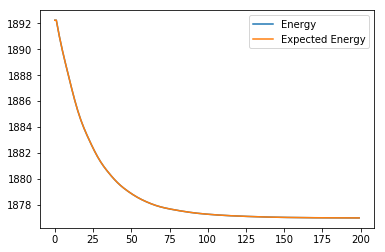

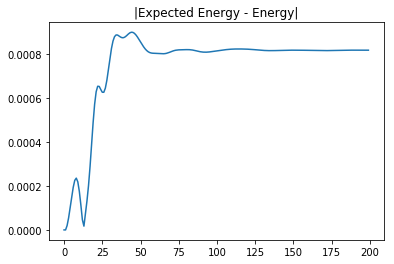

Number of time steps with increasing energy: 0


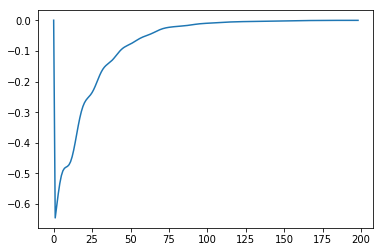

In [8]:
energy = plot_energy(Q1, Q2, r, Lx, Nt, sigma, M, L1, t_final, A0, gamma, stiffness_matrix)
energy_ = plot_energy((Psi @ Q1_.T).T, (Psi @ Q2_.T).T, (Psi @ r_.T).T, Lx, Nt, sigma, M, L1, t_final, A0, gamma, stiffness_matrix)

energy_ = np.array(energy_)
plt.plot(np.arange(len(energy_)-1), energy_[1:] - energy_[:-1])
print("Number of time steps with increasing energy:", np.sum(energy_[1:] - energy_[:-1] > 0))

## Relative Error (POD FEM compared to Vanilla FEM Ground Truth)

0.009420414580294502 0.0007527397396466567


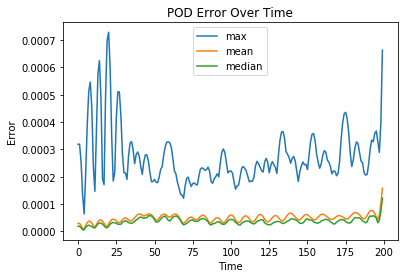

In [9]:
print(np.mean(np.abs(((Psi @ Q1_.T).T - Q1)/Q1)), np.median(np.abs(((Psi @ Q1_.T).T - Q1)/Q1)))
plt.plot(np.arange(Q1.shape[0]), np.max(np.abs(Psi @ Q1_.T - Q1.T), axis=0), label="max")
plt.plot(np.arange(Q1.shape[0]), np.mean(np.abs(Psi @ Q1_.T - Q1.T), axis=0), label="mean")
plt.plot(np.arange(Q1.shape[0]), np.median(np.abs(Psi @ Q1_.T - Q1.T), axis=0), label="median")
plt.legend()
plt.title("POD Error Over Time")
plt.xlabel("Time")
plt.ylabel("Error")
plt.show()

## Visualization

### Vanilla FEM

c:\python37\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


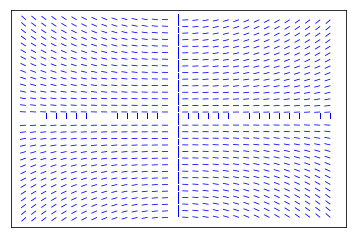

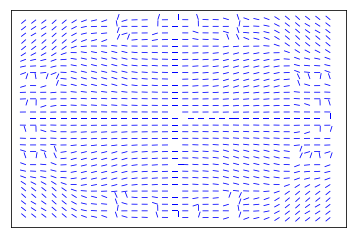

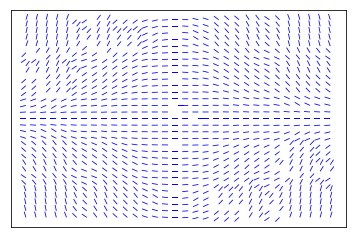

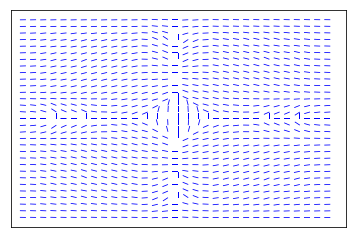

In [10]:
visualize(interior_point_coords, Q1, Q2, r, 
          num_interior_points, Nt, sigma, M, L1, t_final, A0, every=50)

### POD FEM

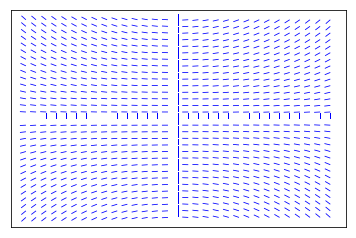

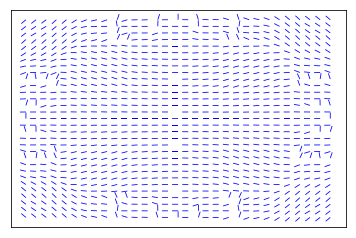

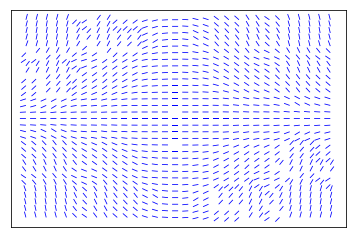

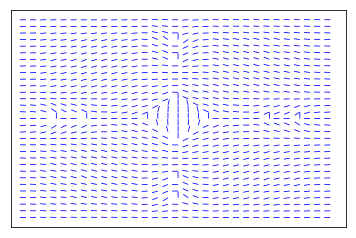

In [11]:
visualize(interior_point_coords, (Psi @ Q1_.T).T, (Psi @ Q2_.T).T, (Psi @ r_.T).T, 
          num_interior_points, Nt, sigma, M, L1, t_final, A0, every=50)

## Same POD Basis, Different Parameters

In [12]:
# set new parameters
a = -0.314
b = 0.141
c = 0.272
A0 = 400
M = 0.5
sigma = 0.75
L1 = 0.5

In [13]:
Q1, Q2, p1, p2, r, num_interior_points = initialize_Q_flow(interior_point_coords, Nt, a, b, c, A0)
solve_Q_flow(Q1, Q2, p1, p2, r, gamma, stiffness_matrix, Lx, t_final, Nt, a, b, c, A0, M, sigma, L1, dt)

Q1_, Q2_, p1_, p2_, r_ = initialize_Q_flow_POD(Q1, Q2, p1, p2, r, Psi, mass_matrix)
solve_Q_flow_POD(Q1_, Q2_, p1_, p2_, r_, Psi, Lambda, stiffness_matrix, mass_matrix, Lx, t_final, Nt, a, b, c, A0, M, sigma, L1, dt)

Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 198/198 [00:04<00:00, 42.93it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 198/198 [00:02<00:00, 75.31it/s]


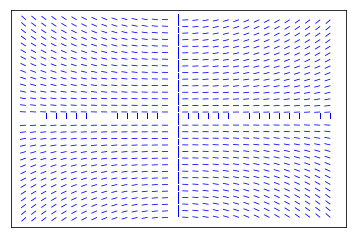

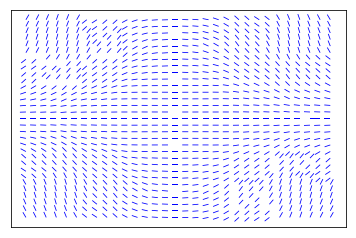

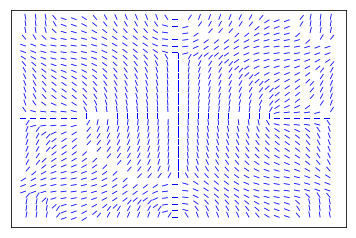

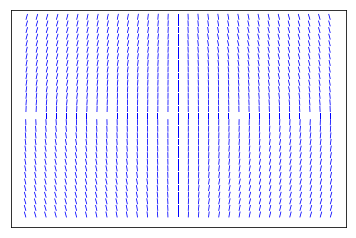

In [14]:
visualize(interior_point_coords, Q1, Q2, r, 
          num_interior_points, Nt, sigma, M, L1, t_final, A0, every=50)

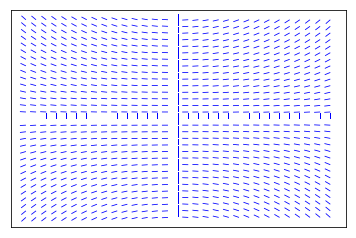

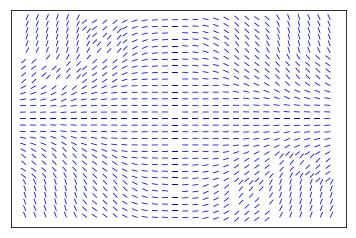

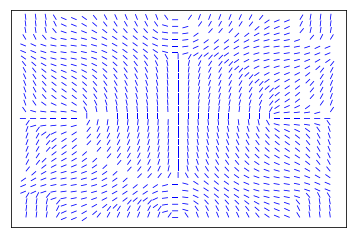

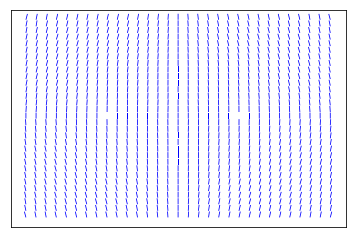

In [15]:
visualize(interior_point_coords, (Psi @ Q1_.T).T, (Psi @ Q2_.T).T, r_, 
          num_interior_points, Nt, sigma, M, L1, t_final, A0, every=50)

0.22205423786069123 0.01956149445516013


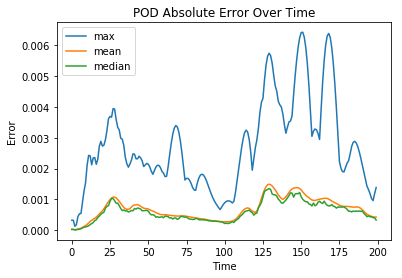

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:09<00:00, 21.45it/s]


0.9956465921279731


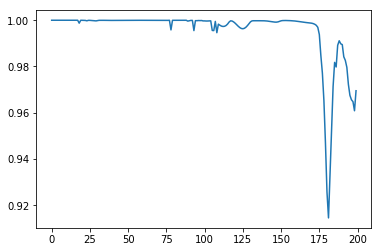

In [16]:
print(np.mean(np.abs(((Psi @ Q1_.T).T - Q1)/Q1)), np.median(np.abs(((Psi @ Q1_.T).T - Q1)/Q1)))
plt.plot(np.arange(Q1.shape[0]), np.max(np.abs(Psi @ Q1_.T - Q1.T), axis=0), label="max")
plt.plot(np.arange(Q1.shape[0]), np.mean(np.abs(Psi @ Q1_.T - Q1.T), axis=0), label="mean")
plt.plot(np.arange(Q1.shape[0]), np.median(np.abs(Psi @ Q1_.T - Q1.T), axis=0), label="median")
plt.legend()
plt.title("POD Absolute Error Over Time")
plt.xlabel("Time")
plt.ylabel("Error")
plt.show()

# Average absolute cosine of angle between solutions

Psi_Q1 = (Psi @ Q1_.T).T
Psi_Q2 = (Psi @ Q2_.T).T
average_cosine = 0
cosines_time = []
for time in tqdm(range(Q1.shape[0]), position=0, leave=True):
    cosines_time.append(0)
    for x in range(Q1.shape[1]):
        Q = np.array([
            [Q1[time,x], Q2[time,x]],
            [Q2[time,x], -Q1[time,x]]
        ])
        
        Q_ = np.array([
            [Psi_Q1[time,x], Psi_Q2[time,x]],
            [Psi_Q2[time,x], -Psi_Q1[time,x]]
        ])
        
        eigenvalues, eigenvectors = np.linalg.eigh(Q)
        eigenvalues_, eigenvectors_ = np.linalg.eigh(Q_)
        
        v = eigenvectors[:, 1]
        v_ = eigenvectors_[:, 1]
        
        cosine = np.abs(np.dot(v, v_))
        average_cosine += cosine
        cosines_time[-1] += cosine
    cosines_time[-1] /= Q1.shape[1]
average_cosine /= Q1.shape[0] * Q1.shape[1]
print(average_cosine)
plt.plot(np.arange(Q1.shape[0]), cosines_time)
plt.show()

In [17]:
# reset to old parameters
a = -0.2
b = 1
c = 1
A0 = 500
M = 1
sigma = 1.0
L1 = 0.1

## Error Experiment
First we do a course FE simulation. Then we do a refined FE simulation. After that, we compute a POD basis of rank $\ell$ for various $\ell$, and compute the error for the course simulation and each POD simulation based on the refined simulation.

Perhaps try measuring the average cosine of the angle between the directors (we want it close to 1)

In [18]:
def compute_absolute_errors(Q1, Q2, point_coords, Q1_, Q2_, point_coords_):
    errors = []
    for t in tqdm(range(Q1.shape[0]), position=0, leave=True):
        errors.append(compute_absolute_error_at_t(Q1[t], Q2[t], point_coords,
                                                  Q1_[t], Q2_[t], point_coords_))
    return np.array(errors)

def compute_absolute_error_at_t(Q1, Q2, point_coords, Q1_, Q2_, point_coords_):
    """
    Computes the mean absolute error between course mesh and refined mesh
    for a single time.
    
    Q1_, Q2_, point_coords_ are from the refined mesh
    """
    error = 0
    for i, coord in enumerate(point_coords):
        for i_, coord_ in enumerate(point_coords_):
            if np.isclose(coord, coord_).all():
                error += np.abs((Q1[i] - Q1_[i_]))
                error += np.abs((Q2[i] - Q2_[i_]))
                break
    error /= (2 * Q1.shape[0])
    return error

Computing course FE simulation...
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 121.50it/s]


Computing refined FE simulation...
Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [01:21<00:00,  1.33it/s]


Course Mesh Error: 0.021098210525783867
Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [01:30<00:00,  1.17it/s]


Rank 5 Error: 0.03626127127741865
Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [01:27<00:00,  1.21s/it]


Rank 10 Error: 0.023804447295756873
Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [01:18<00:00,  1.11it/s]


Rank 15 Error: 0.021269077487952287
Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [01:16<00:00,  1.21it/s]


Rank 20 Error: 0.02110385985315449


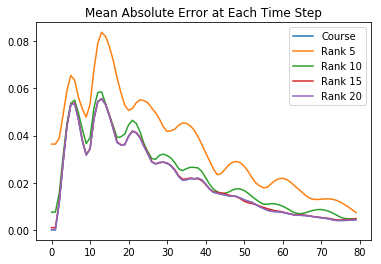

In [19]:
# number of time steps and final time
Nt = 80
t_final = 5
tVals = np.linspace(0, t_final, Nt)
dt = tVals[1] - tVals[0] # delta t

"""
Course simulation
"""
print("Computing course FE simulation...")
# define the mesh in space
mesh, interior_point_coords = get_triangulation(refinements=4)

Q1, Q2, p1, p2, r, num_interior_points = initialize_Q_flow(interior_point_coords, Nt, a, b, c, A0)

# Get the finite element space, stiffness matrix, lumped mass matrix as a vector, and mass matrix
Vh, stiffness_matrix, gamma, mass_matrix = calculate_basis_integrals(mesh)

# solve the PDE (updates the entries of Q1, Q2, etc. within the function)
solve_Q_flow(Q1, Q2, p1, p2, r, gamma, stiffness_matrix, Lx, t_final, Nt, a, b, c, A0, M, sigma, L1, dt)

"""
Refined simulation
"""
print("Computing refined FE simulation...")
mesh_r, interior_point_coords_r = get_triangulation(refinements=5)
Q1_r, Q2_r, p1_r, p2_r, r_r, num_interior_points = initialize_Q_flow(interior_point_coords_r, Nt, a, b, c, A0)

# Get the finite element space, stiffness matrix, lumped mass matrix as a vector, and mass matrix
Vh_r, stiffness_matrix_r, gamma_r, mass_matrix_r = calculate_basis_integrals(mesh_r)

# solve the PDE (updates the entries of Q1, Q2, etc. within the function)
solve_Q_flow(Q1_r, Q2_r, p1_r, p2_r, r_r, gamma_r, stiffness_matrix_r, Lx, t_final, Nt, a, b, c, A0, M, sigma, L1, dt)

# plot the error
course_errors = compute_absolute_errors(Q1, Q2, interior_point_coords, Q1_r, Q2_r, interior_point_coords_r)
print("Course Mesh Error:", np.mean(course_errors))
plt.plot(np.arange(len(course_errors)), course_errors, label="Course")

"""
POD simulation of rank \ell
"""
Lambda = np.diag(gamma)
for ell in [5, 10, 15, 20]:
    Psi = get_Psi(Q1, Q2, r, dt, mass_matrix, rank=ell)
    Q1_, Q2_, p1_, p2_, r_ = initialize_Q_flow_POD(Q1, Q2, p1, p2, r, Psi, mass_matrix)
    solve_Q_flow_POD(Q1_, Q2_, p1_, p2_, r_, Psi, Lambda, stiffness_matrix, mass_matrix, Lx, t_final, Nt, a, b, c, A0, M, sigma, L1, dt)
    # plot the error
    ell_errors = compute_absolute_errors((Psi @ Q1_.T).T, (Psi @ Q2_.T).T, interior_point_coords, Q1_r, Q2_r, interior_point_coords_r)
    print(f"Rank {ell} Error:", np.mean(ell_errors))
    plt.plot(np.arange(len(ell_errors)), ell_errors, label=f"Rank {ell}")

plt.legend()
plt.title("Mean Absolute Error at Each Time Step")
plt.show()

## Increasing Number of Nodes in Non-POD Mesh

Computing refined FE simulation...
Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:14<00:00,  5.19it/s]


Computing course FE simulation...
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 182.67it/s]


Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:03<00:00, 20.52it/s]


49 Degrees of Freedom Error: 0.04846273681829104
Computing course FE simulation...
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 164.20it/s]


Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [01:16<00:00,  1.19s/it]


225 Degrees of Freedom Error: 0.01890525385459332


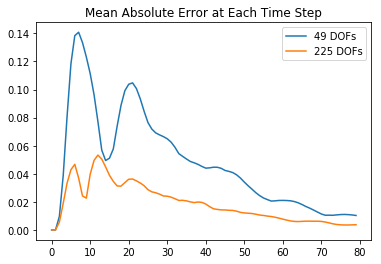

In [20]:
"""
Refined simulation
"""
print("Computing refined FE simulation...")
mesh_r, interior_point_coords_r = get_triangulation(refinements=6)
Q1_r, Q2_r, p1_r, p2_r, r_r, num_interior_points = initialize_Q_flow(interior_point_coords_r, Nt, a, b, c, A0)

# Get the finite element space, stiffness matrix, lumped mass matrix as a vector, and mass matrix
Vh_r, stiffness_matrix_r, gamma_r, mass_matrix_r = calculate_basis_integrals(mesh_r)

# solve the PDE (updates the entries of Q1, Q2, etc. within the function)
solve_Q_flow(Q1_r, Q2_r, p1_r, p2_r, r_r, gamma_r, stiffness_matrix_r, Lx, t_final, Nt, a, b, c, A0, M, sigma, L1, dt)

"""

    Calculate the POD basis based on course simulations with different
    numbers of nodes

"""

errors_array = []

for refinement in range(3, 5):

    """
    Course simulation
    """
    print("Computing course FE simulation...")
    # define the mesh in space
    mesh, interior_point_coords = get_triangulation(refinements=refinement)

    Q1, Q2, p1, p2, r, num_interior_points = initialize_Q_flow(interior_point_coords, Nt, a, b, c, A0)

    # Get the finite element space, stiffness matrix, lumped mass matrix as a vector, and mass matrix
    Vh, stiffness_matrix, gamma, mass_matrix = calculate_basis_integrals(mesh)

    # solve the PDE (updates the entries of Q1, Q2, etc. within the function)
    solve_Q_flow(Q1, Q2, p1, p2, r, gamma, stiffness_matrix, Lx, t_final, Nt, a, b, c, A0, M, sigma, L1, dt)
    
    """
    POD simulation
    """
    ell = 30
    Lambda = np.diag(gamma)
    Psi = get_Psi(Q1, Q2, r, dt, mass_matrix, rank=ell)
    
    Q1_, Q2_, p1_, p2_, r_ = initialize_Q_flow_POD(Q1, Q2, p1, p2, r, Psi, mass_matrix)
    solve_Q_flow_POD(Q1_, Q2_, p1_, p2_, r_, Psi, Lambda, stiffness_matrix, mass_matrix, Lx, t_final, Nt, a, b, c, A0, M, sigma, L1, dt)
    # plot the error
    errors = compute_absolute_errors((Psi @ Q1_.T).T, (Psi @ Q2_.T).T, interior_point_coords, Q1_r, Q2_r, interior_point_coords_r)
    errors_array.append(errors)
    print(f"{num_interior_points} Degrees of Freedom Error:", np.mean(errors))
    plt.plot(np.arange(len(errors)), errors, label=f"{num_interior_points} DOFs")

plt.legend()
plt.title("Mean Absolute Error at Each Time Step")
plt.show()

## Speed Experiment

In [21]:
import time

t_final = 5
mesh, interior_point_coords = get_triangulation(refinements=5)
Vh, stiffness_matrix, gamma, mass_matrix = calculate_basis_integrals(mesh)
Lambda = np.diag(gamma)

T_over_dt = [16, 32, 64, 128, 256, 512, 768, 1024]
non_POD_speeds = []
POD_speeds = []
ells = [10, 40]

for Nt in T_over_dt:
    tVals = np.linspace(0, t_final, Nt)
    dt = tVals[1] - tVals[0] # delta t
    
    # non-POD simulation
    Q1, Q2, p1, p2, r, num_interior_points = initialize_Q_flow(interior_point_coords, Nt, a, b, c, A0)
    start = time.time()
    solve_Q_flow(Q1, Q2, p1, p2, r, gamma, stiffness_matrix, Lx, t_final, Nt, a, b, c, A0, M, sigma, L1, dt)
    end = time.time()
    non_POD_speeds.append(end - start)
    
    # POD simulations
    POD_speeds.append([])
    for ell in ells:
        Psi = get_Psi(Q1, Q2, r, dt, mass_matrix, rank=ell)
        Q1_, Q2_, p1_, p2_, r_ = initialize_Q_flow_POD(Q1, Q2, p1, p2, r, Psi, mass_matrix)
        start = time.time()
        solve_Q_flow_POD(Q1_, Q2_, p1_, p2_, r_, Psi, Lambda, stiffness_matrix, mass_matrix, Lx, t_final, Nt, a, b, c, A0, M, sigma, L1, dt)
        end = time.time()
        POD_speeds[-1].append(end - start)

Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 47.78it/s]


Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 280.01it/s]


Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 153.84it/s]


Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.99it/s]


Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 225.56it/s]


Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 153.85it/s]


Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:01<00:00, 50.41it/s]


Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 238.46it/s]


Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 150.86it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:03<00:00, 36.71it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████| 126/126 [00:00<00:00, 161.96it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████| 126/126 [00:00<00:00, 138.16it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 254/254 [00:05<00:00, 52.32it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████| 254/254 [00:01<00:00, 132.78it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████| 254/254 [00:02<00:00, 112.94it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 510/510 [00:08<00:00, 59.73it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████| 510/510 [00:03<00:00, 129.28it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 510/510 [00:05<00:00, 85.53it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 766/766 [00:13<00:00, 57.76it/s]


Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████| 766/766 [00:07<00:00, 100.61it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 766/766 [00:10<00:00, 75.72it/s]


Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████| 1022/1022 [00:20<00:00, 48.81it/s]


Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████| 1022/1022 [00:17<00:00, 58.28it/s]


Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████| 1022/1022 [00:22<00:00, 46.00it/s]


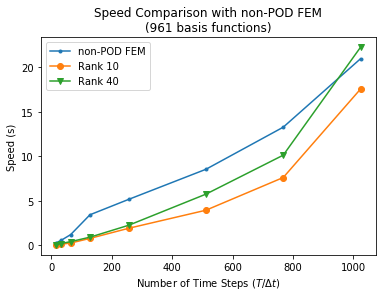

In [22]:
markers = [".", "o", "v", "^", "s"]

plt.plot(T_over_dt, non_POD_speeds, label="non-POD FEM", marker=markers[0])
POD_speeds = np.array(POD_speeds)
for i, ell in enumerate(ells):
    plt.plot(T_over_dt, POD_speeds[:, i], label=f"Rank {ell}", marker=markers[i+1])
plt.legend()
plt.ylabel("Speed (s)")
plt.xlabel("Number of Time Steps ($T/\Delta t$)")
plt.title(f"Speed Comparison with non-POD FEM\n({interior_point_coords.shape[0]} basis functions)")
plt.show()

In [23]:
t_final = 5
mesh, interior_point_coords = get_triangulation(refinements=6)
Vh, stiffness_matrix, gamma, mass_matrix = calculate_basis_integrals(mesh)
Lambda = np.diag(gamma)

T_over_dt = [8, 16, 32, 64, 128, 256, 512, 768, 1024]
non_POD_speeds = []
POD_speeds = []
ells = [10, 40]

for Nt in T_over_dt:
    tVals = np.linspace(0, t_final, Nt)
    dt = tVals[1] - tVals[0] # delta t
    
    # non-POD simulation
    Q1, Q2, p1, p2, r, num_interior_points = initialize_Q_flow(interior_point_coords, Nt, a, b, c, A0)
    start = time.time()
    solve_Q_flow(Q1, Q2, p1, p2, r, gamma, stiffness_matrix, Lx, t_final, Nt, a, b, c, A0, M, sigma, L1, dt)
    end = time.time()
    non_POD_speeds.append(end - start)
    
    # POD simulations
    POD_speeds.append([])
    for ell in ells:
        Psi = get_Psi(Q1, Q2, r, dt, mass_matrix, rank=ell)
        Q1_, Q2_, p1_, p2_, r_ = initialize_Q_flow_POD(Q1, Q2, p1, p2, r, Psi, mass_matrix)
        start = time.time()
        solve_Q_flow_POD(Q1_, Q2_, p1_, p2_, r_, Psi, Lambda, stiffness_matrix, mass_matrix, Lx, t_final, Nt, a, b, c, A0, M, sigma, L1, dt)
        end = time.time()
        POD_speeds[-1].append(end - start)

Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  5.52it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 88.23it/s]
C:\Users\maxhi\OneDrive\Desktop\CMU\SURF\FEM\POD\pod_fem.py:45: RuntimeWarning: invalid value encountered in sqrt
  Psi = Q_tilde @ retained_vecs @ np.diag(np.sqrt(dt/retained_vals))


Computing scheme...


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]c:\python37\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:206: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)
100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 82.20it/s]


Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  5.49it/s]


Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 123.90it/s]


Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 71.07it/s]


Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.47it/s]


Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 102.04it/s]


Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 69.12it/s]


Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:11<00:00,  5.45it/s]


Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 101.97it/s]


Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:01<00:00, 61.63it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:25<00:00,  4.47it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:01<00:00, 72.41it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:02<00:00, 44.27it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 254/254 [00:53<00:00,  5.03it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 254/254 [00:04<00:00, 60.39it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 254/254 [00:06<00:00, 41.50it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 510/510 [01:46<00:00,  4.87it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 510/510 [00:16<00:00, 31.32it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 510/510 [00:21<00:00, 23.30it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 766/766 [02:48<00:00,  4.56it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 766/766 [00:38<00:00, 19.96it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 766/766 [00:41<00:00, 18.06it/s]


Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████| 1022/1022 [03:46<00:00,  4.41it/s]


Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████| 1022/1022 [01:11<00:00, 14.85it/s]


Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████| 1022/1022 [01:27<00:00, 11.67it/s]


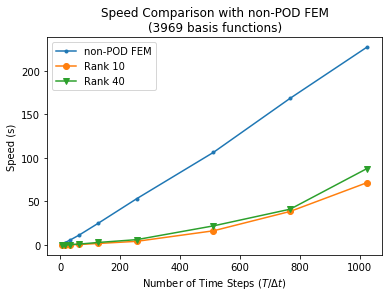

In [24]:
markers = [".", "o", "v", "^", "s"]

plt.plot(T_over_dt, non_POD_speeds, label="non-POD FEM", marker=markers[0])
POD_speeds = np.array(POD_speeds)
for i, ell in enumerate(ells):
    plt.plot(T_over_dt, POD_speeds[:, i], label=f"Rank {ell}", marker=markers[i+1])
plt.legend()
plt.ylabel("Speed (s)")
plt.xlabel("Number of Time Steps ($T/\Delta t$)")
plt.title(f"Speed Comparison with non-POD FEM\n({interior_point_coords.shape[0]} basis functions)")
plt.show()

## Energy Stability Revisited

In [25]:
Lx = 2 

# model parameters
a = -0.2
b = 1
c = 1
A0 = 500
M = 1
sigma = 1.0
L1 = 0.1

# number of time steps and final time
Nt = 200
t_final = 5
tVals = np.linspace(0, t_final, Nt)
dt = tVals[1] - tVals[0] # delta t

In [26]:
mesh, interior_point_coords = get_triangulation(refinements=5)

# Get vectors for the components of matrices (flattened over space) 
# over time with time 0 initialized.
# We only keep track of nodes in the interior of \Omega because we
# use homogeneous Dirichlet boundary conditions.
Q1, Q2, p1, p2, r, num_interior_points = initialize_Q_flow(interior_point_coords, Nt, a, b, c, A0)

# Get the finite element space, stiffness matrix, lumped mass matrix as a vector, and mass matrix
Vh, stiffness_matrix, gamma, mass_matrix = calculate_basis_integrals(mesh)

# solve the PDE (updates the entries of Q1, Q2, etc. within the function)
solve_Q_flow(Q1, Q2, p1, p2, r, gamma, stiffness_matrix, Lx, t_final, Nt, a, b, c, A0, M, sigma, L1, dt)

Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 198/198 [00:04<00:00, 46.69it/s]


In [27]:
Psi = get_Psi(Q1, Q2, r, dt, mass_matrix, rank=2)
Lambda = np.diag(gamma)
Q1_, Q2_, p1_, p2_, r_ = initialize_Q_flow_POD(Q1, Q2, p1, p2, r, Psi, mass_matrix)

solve_Q_flow_POD(Q1_, Q2_, p1_, p2_, r_, Psi, Lambda, stiffness_matrix, mass_matrix, Lx, t_final, Nt, a, b, c, A0, M, sigma, L1, dt)

Computing scheme...


100%|███████████████████████████████████████████████████████████████████████████████| 198/198 [00:01<00:00, 175.07it/s]


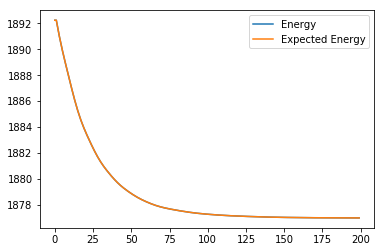

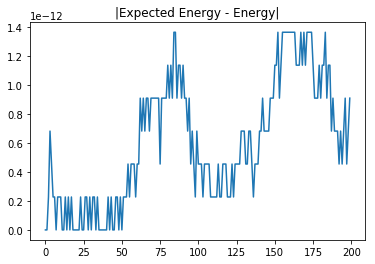

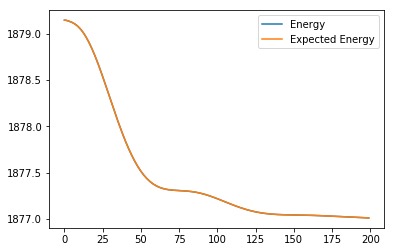

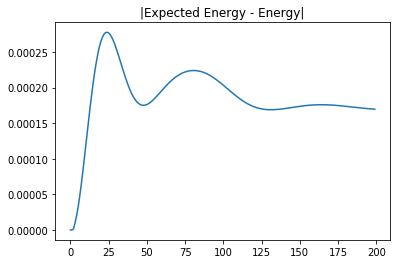

Number of time steps with increasing energy: 0


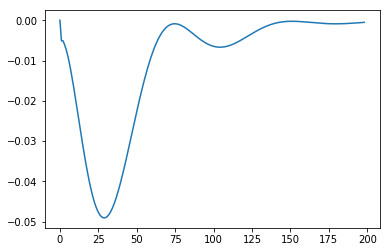

In [28]:
energy = plot_energy(Q1, Q2, r, Lx, Nt, sigma, M, L1, t_final, A0, gamma, stiffness_matrix)
energy_ = plot_energy((Psi @ Q1_.T).T, (Psi @ Q2_.T).T, (Psi @ r_.T).T, Lx, Nt, sigma, M, L1, t_final, A0, gamma, stiffness_matrix)

energy_ = np.array(energy_)
plt.plot(np.arange(len(energy_)-1), energy_[1:] - energy_[:-1])
print("Number of time steps with increasing energy:", np.sum(energy_[1:] - energy_[:-1] > 0))

In [29]:
mesh, interior_point_coords = get_triangulation(refinements=4)
interior_point_coords.shape

(225, 2)